## This script creates a CNN model that can predict image classes based on road function and amenities. It utilizes a manually classified dataset of 406 images and a Resnet34 model pretrained on ImageNet and applies transfer learning to combine these two.

### This block imports all necessary packages and imports some data

In [2]:
#Processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import linemerge
from pathlib import Path
from PIL import Image
import os
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#PyTorch
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torchvision.models import ResNet34_Weights 


data_path = Path('London_UK')

panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
network = gpd.read_file(data_path / 'network/edges/edges.geojson')

### Creates dataframe with connected data

In [3]:
streets = network 

images_df = pd.DataFrame({
    'image_id': np.arange(len(panoids)),
    'longitude': panoids.lng,
    'latitude': panoids.lat,
})

images_gdf = gpd.GeoDataFrame(
    images_df, 
    geometry=gpd.points_from_xy(images_df['longitude'], images_df['latitude']), 
    crs='EPSG:4326'  #WGS 84
)

if streets.crs is None:
    streets.set_crs('EPSG:4326', inplace=True)

projected_crs = 'EPSG:27700' #British national grid of London

images_gdf = images_gdf.to_crs(projected_crs)
streets = streets.to_crs(projected_crs)

matched = gpd.sjoin_nearest(images_gdf, streets, how='left', distance_col='distance')
matched = matched.to_crs('EPSG:4326')

matched #Showcasing the matched data

,image_id,longitude,latitude,geometry,index_right,level_0,level_1,u,v,key,distance
0,0,-0.107827,51.510414,POINT (-0.10783 51.51041),1130,2235,0,1239564303,4175081593,0,52.581153
1,1,-0.107077,51.510418,POINT (-0.10708 51.51042),1130,2235,0,1239564303,4175081593,0,51.745758
2,2,-0.108574,51.510413,POINT (-0.10857 51.51041),1181,4135,0,4175081594,4697288399,0,53.584166
3,3,-0.108627,51.510975,POINT (-0.10863 51.51098),1184,3965,0,3911044734,3992885062,0,2.178945
4,4,-0.108001,51.510957,POINT (-0.108 51.51096),1137,3304,0,2341656968,4085747017,0,0.275572
...,...,...,...,...,...,...,...,...,...,...,...
9008,9008,-0.080453,51.521826,POINT (-0.08045 51.52183),5477,4177,1,4316306163,6711365597,0,1.027178
9009,9009,-0.080415,51.521814,POINT (-0.08041 51.52181),5477,4177,1,4316306163,6711365597,0,0.764215
9010,9010,-0.080423,51.521812,POINT (-0.08042 51.52181),5477,4177,1,4316306163,6711365597,0,0.421528
9011,9011,-0.080425,51.521810,POINT (-0.08043 51.52181),5477,4177,1,4316306163,6711365597,0,0.051064


### Splits the lines longer than 100 meters into 50 meter segments and creates a new dataframe with these segments

In [4]:
def split_line(line, max_segment_length=50):
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    return [LineString([line.interpolate(i * segment_length), 
                        line.interpolate(min((i + 1) * segment_length, line.length))]) 
            for i in range(num_segments)]

streets = gpd.read_file('London_UK/network/edges/edges.geojson')
streets = streets.to_crs(epsg=28992) if streets.crs.is_geographic else streets

split_segments = [seg for _, row in streets.iterrows() 
                  for seg in (split_line(row.geometry, 50) if row.geometry.length > 100 else [row.geometry])]

split_streets_gdf = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)

print(split_streets_gdf)

                                               geometry
0     LINESTRING (-224559.45 405323.931, -224588.869...
1     LINESTRING (-224588.869 405310.835, -224632.67...
2     LINESTRING (-224632.678 405322.537, -224676.53...
3     LINESTRING (-224713.082 405344.849, -224676.53...
4     LINESTRING (-224713.082 405344.849, -224736.85...
...                                                 ...
5807  LINESTRING (-224265.34 406775.406, -224232.712...
5808  LINESTRING (-224232.712 406769.725, -224197.67...
5809  LINESTRING (-224197.674 406755.318, -224161.70...
5810  LINESTRING (-224250.452 406784.135, -224247.72...
5811  LINESTRING (-224247.727 406782.858, -224182.29...

[5812 rows x 1 columns]


### Merges short lines into longer segments

In [5]:
def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments, current_merge = [], []

    for line in streets_gdf.geometry:
        if line.length < max_individual_length:
            current_merge.append(line)
            if sum(seg.length for seg in current_merge) >= min_total_length:
                merged_segments.append(linemerge(current_merge))
                current_merge = []
        else:
            if current_merge:
                merged_segments.append(linemerge(current_merge))
                current_merge = []
            merged_segments.append(line)

    if current_merge:
        merged_segments.append(linemerge(current_merge))

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)

merged_streets_gdf = merge_short_lines(split_streets_gdf)
merged_streets_gdf['length'] = merged_streets_gdf.length

print(merged_streets_gdf.head())

                                            geometry     length
0  LINESTRING (-224559.45 405323.931, -224588.869...  32.202141
1  LINESTRING (-224588.869 405310.835, -224632.67...  45.345370
2  LINESTRING (-224632.678 405322.537, -224676.53...  45.345382
3  LINESTRING (-224713.082 405344.849, -224676.53...  38.105447
4  LINESTRING (-224713.082 405344.849, -224736.85...  27.635476


## ROAD FUNCTION

### Takes all manually classified images (406) regarding **road function** and stores them in separate folders

In [6]:
base_dir = 'D:/School2(M)/DSAIE/STREET/London_UK/imagedb' #Change this to where the full image database is located
destination_dir = 'D:/School2(M)/DSAIE/STREET-main/STREET-main/Classified_Images' #Change this to where the sorted images should be copied to

categories = {
    'residential_road': [
        "410_s_a", "410_f", "410_s_b", "410_b", "417_s_a", "417_s_b", "568_s_a", "568_f", "568_s_b", "619_f",
        "619_s_b", "619_b", "754_f", "754_s_b", "754_b", "806_s_a", "806_f", "806_s_b", "806_b", "981_f",
        "981_b", "1116_s_a", "1116_f", "1116_s_b", "1116_b", "1430_s_a", "1430_f", "1430_s_b", "1430_b",
        "1465_s_b", "1750_s_a", "1750_f", "1750_s_b", "1750_b", "2166_s_a", "2497_f", "2497_b", "3235_s_a",
        "3235_f", "3235_s_b", "3235_b", "3264_f", "3264_b", "3757_s_a", "3757_f", "3757_s_b", "3757_b",
        "3797_s_a", "3797_f", "3797_s_b", "3797_b", "3852_f", "3852_s_b", "3852_b", "4142_s_a", "4142_f",
        "4142_s_b", "4142_b", "4187_s_a", "4187_f", "4187_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4810_s_a", "4810_f", "4880_s_a", "4880_f", "4880_s_b", "4880_b", "4985_s_a", "5074_s_a", "5074_f",
        "5074_s_b", "5079_f", "5079_b", "5136_s_a", "5136_f", "5136_s_b", "5136_b", "5160_f", "5160_b",
        "5338_s_a", "5338_f", "5338_s_b", "5338_b", "5379_s_a", "5379_s_b", "5869_f", "5869_s_b", "5869_b",
        "6417_s_a", "6417_f", "6417_s_b", "6417_b", "7028_f", "7028_b", "7039_f", "7039_b", "7486_f",
        "7486_b", "7795_s_a", "7795_f", "7795_b", "7822_s_a", "7822_f", "7822_s_b", "7822_b", "8285_f",
        "8324_s_a", "8324_s_b", "8346_s_a", "8346_f", "8346_s_b", "8346_b", "8435_s_a", "8435_f", "8435_s_b",
        "8435_b", "8594_s_a", "8594_f", "8594_s_b", "8594_b"
    ],
    'main_road': [
        "148_s_a", "148_f", "148_s_b", "148_b", "417_f", "417_b", "466_s_a", "466_f", "466_s_b", "466_b",
        "504_s_a", "504_f", "504_s_b", "504_b", "568_b", "582_s_a", "582_s_b", "582_b", "590_f", "590_s_b",
        "590_b", "811_s_a", "811_f", "811_b", "940_f", "940_s_b", "940_b", "946_s_a", "946_f", "946_s_b",
        "946_b", "1302_s_a", "1302_b", "1334_f", "1334_b", "1465_f", "1465_b", "1568_s_a", "2145_f", "2145_s_b",
        "2145_b", "2166_f", "2166_b", "2206_s_a", "2206_f", "2206_s_b", "2206_b", "2281_s_a", "2281_f", "2281_s_b",
        "2281_b", "2410_s_a", "2410_f", "2410_s_b", "2980_f", "2980_b", "2991_s_a", "2991_f", "2991_s_b", "2999_s_a",
        "2999_f", "2999_s_b", "2999_b", "3310_s_a", "3310_f", "3310_s_b", "3310_b", "3456_f", "3456_s_b", "3456_b",
        "3640_s_a", "3640_f", "3640_b", "3759_s_a", "3759_f", "3759_s_b", "3759_b", "3836_s_a", "3836_f", "3836_s_b",
        "3836_b", "4003_f", "4003_s_b", "4003_b", "4010_f", "4010_b", "4090_s_a", "4090_f", "4090_s_b", "4090_b",
        "4356_s_a", "4356_f", "4356_s_b", "4356_b", "4527_s_a", "4527_f", "4527_s_b", "4527_b", "4551_s_a", "4551_f",
        "4551_b", "4679_s_a", "4679_f", "4679_s_b", "4679_b", "4699_s_a", "4699_f", "4699_s_b", "4699_b", "4724_s_a",
        "4724_f", "4724_s_b", "4724_b", "4768_f", "4768_s_b", "4768_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4985_s_a", "4985_f", "4985_s_b", "4985_b", "5190_s_a", "5190_f", "5190_s_b", "5190_b", "5379_s_a", "5379_f",
        "5379_b", "5411_s_a", "5411_f", "5411_b", "6125_f", "6125_b", "6558_f", "6558_b", "6793_s_a", "6793_f",
        "6793_s_b", "6793_b", "6954_s_a", "6954_f", "6954_s_b", "6985_s_a", "6985_f", "6985_s_b", "6985_b", "7062_s_a",
        "7062_f", "7062_s_b", "7062_b", "7074_f", "7074_s_b", "7074_b", "7155_s_a", "7155_f", "7155_s_b", "7155_b",
        "7499_b", "7715_s_a", "7715_f", "7715_s_b", "7715_b", "7973_f", "7973_b", "8009_s_a", "8009_f", "8009_s_b",
        "8009_b", "8285_s_b", "8285_b", "8324_s_a", "8324_f", "8324_s_b", "8324_b", "8391_s_a", "8391_f", "8391_s_b",
        "8971_s_a", "8971_f", "8971_s_b", "8971_b"
    ],
    'pedestrian_road': [
        "582_f", "590_s_a", "619_s_a", "619_s_b", "754_s_a", "754_b", "806_s_a", "806_f", "806_s_b", "806_b",
        "811_s_b", "940_s_a", "981_s_a", "981_s_b", "1263_s_a", "1263_f", "1263_s_b", "1263_b", "1302_f", "1302_s_b",
        "1334_s_a", "1334_s_b", "1465_s_a", "1465_s_b", "1485_s_a", "1485_f", "1485_s_b", "1485_b", "1568_f", "1568_s_b",
        "1568_b", "2145_s_a", "2166_s_b", "2410_b", "2497_s_b", "2980_s_a", "2980_s_b", "2991_b", "3264_s_a", "3264_s_b",
        "3456_s_a", "3640_s_b", "3852_s_a", "4003_s_a", "4010_s_a", "4010_s_b", "4187_s_a", "4187_s_b", "4551_s_b",
        "4768_s_a", "4810_s_a", "4810_b", "5074_b", "5079_s_a", "5079_s_b", "5160_s_a", "5160_s_b", "5338_s_a", "5338_s_b",
        "5411_s_b", "5869_s_a", "6125_s_a", "6125_s_b", "6558_s_a", "6558_s_b", "6954_b", "6955_s_a", "6955_f", "6955_s_b",
        "6955_b", "7028_s_a", "7028_s_b", "7039_s_a", "7039_s_b", "7074_s_a", "7166_s_a", "7166_f", "7166_s_b", "7166_b",
        "7486_s_a", "7486_s_b", "7499_s_a", "7499_f", "7499_s_b", "7795_s_b", "7973_s_a", "7973_s_b", "8285_s_a", "8285_f",
        "8391_b", "8709_s_a", "8709_f", "8709_s_b", "8709_b", "8784_s_a", "8784_f", "8784_s_b", "8784_b"
    ]
}

for category, filenames in categories.items():
    category_path = os.path.join(destination_dir, category)
    os.makedirs(category_path, exist_ok=True)
    
    for filename in filenames:
        image_path = os.path.join(base_dir, f"image_{filename}.png")
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(category_path, f"image_{filename}.png"))
        else:
            print(f"Image not found: {image_path}")
    print(f"Images copied to {category_path}")

print("✅ All images have been sorted into subfolders.")

Images copied to D:/School2(M)/DSAIE/STREET-main/STREET-main/Classified_Images\residential_road
Images copied to D:/School2(M)/DSAIE/STREET-main/STREET-main/Classified_Images\main_road
Images copied to D:/School2(M)/DSAIE/STREET-main/STREET-main/Classified_Images\pedestrian_road
✅ All images have been sorted into subfolders.


### This will compute the Mean and std tensor of the manually classified images, needed for training and normalization later on

In [7]:
data_dir = 'D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_Images' #This should be Classified_Images folder where the manually classified images were stored in
dataset = ImageFolder(root=data_dir, transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean_road = torch.tensor([0.0, 0.0, 0.0])
std_road = torch.tensor([0.0, 0.0, 0.0])
for images, _ in loader:
    # Compute mean and std per batch
    batch_mean = torch.mean(images, dim=[0, 2, 3])
    batch_std = torch.std(images, dim=[0, 2, 3])
    mean_road += batch_mean
    std_road += batch_std
mean_road /= len(loader)
std_road /= len(loader)

print(f"Dataset Mean: {mean_road}, Dataset Std: {std_road}")

Dataset Mean: tensor([0.4205, 0.4171, 0.4113]), Dataset Std: tensor([0.2165, 0.2145, 0.2206])


### We decided to train Resnet18 and Resnet34. We opted out of vgg16 for practicality, since training VGG took too long. To prevent Resnet34 from overfitting on our small manually classified dataset (406 images), we applied data augmentation and dropout. Furthermore, this block splits the data into train-val-test sets, sets up the two Resnet models and prepares for transfer learning.

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_road, std=std_road)
])

data_dir = 'D:\\School2(M)\\DSAIE\\STREET\\classified_data'
train_dataset = ImageFolder(root=data_dir, transform=transform)

#Split the dataset into train (70%), val (20%), and test (10%)
num_train = int(0.7 * len(train_dataset))
num_val = int(0.2 * len(train_dataset))
num_test = len(train_dataset) - num_train - num_val

train_data, val_data, test_data = random_split(train_dataset, [num_train, num_val, num_test])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(model_name, num_classes): #VGG16 takes too long to train
    if model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Unfreeze (final) classification layer
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Sequential(
        nn.Dropout(0.5), 
        nn.Linear(model.fc.in_features, num_classes))
    
    return model.to(device)

### Defines and applies the model trainer. Evaluates their validation accuracy and saves best-performing model. For analysis, we computed validation metrics. We tried a few different optimizers and found that AdamW resulted in the lowest validation loss. The Cross-entropy loss is widely used in classification.

In [30]:
def train(model, train_loader, val_loader, lr=0.005):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss() 
    metrics = {'training losses': [], 'validation losses': [], 'validation accuracies': [], 'validation precisions': [], 'validation recalls': [], 'validation f1 scores': []}
    best_val_accuracy = 0.0

    for epoch in range(15):
        model.train()
        training_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        metrics['training losses'].append(training_loss / len(train_loader))

        model.eval()
        validation_loss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        metrics['validation losses'].append(validation_loss / len(val_loader))
        accuracy = 100 * accuracy_score(true_labels, predicted_labels)
        precision = 100 * precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
        recall = 100 * recall_score(true_labels, predicted_labels, average='macro')
        f1 = 100 * f1_score(true_labels, predicted_labels, average='weighted')

        metrics['validation accuracies'].append(accuracy)
        metrics['validation precisions'].append(precision)
        metrics['validation recalls'].append(recall)
        metrics['validation f1 scores'].append(f1)

        scheduler.step(validation_loss)

        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_model_state = model.state_dict()
            print(f"Epoch {epoch+1}: Improved validation accuracy to {best_val_accuracy:.2f}%.")

        print(f'Epoch {epoch+1}/{10}', f'Train Loss: {metrics["training losses"][-1]:.4f}, ', f'Validation Loss: {metrics["validation losses"][-1]:.4f}, ', f'Accuracy: {metrics["validation accuracies"][-1]:.2f}%')

    return metrics, best_val_accuracy, best_model_state

#Training and evaluating Resnet18
model_resnet18 = create_model("resnet18", len(train_dataset.classes))
summary(model_resnet18, input_size=(3, 224, 224))
metrics_resnet18, best_val_accuracy_resnet18, best_model_state_resnet18 = train(model_resnet18, train_loader, val_loader)

#Training and evaluating Resnet34
model_resnet34 = create_model("resnet34", len(train_dataset.classes))
summary(model_resnet34, input_size=(3, 224, 224))
metrics_resnet34, best_val_accuracy_resnet34, best_model_state_resnet34 = train(model_resnet34, train_loader, val_loader)

#Determines the best model and saves it
if best_val_accuracy_resnet18 > best_val_accuracy_resnet34:
    best_model_state = best_model_state_resnet18
    best_model_name = "ResNet18"
else:
    best_model_state = best_model_state_resnet34
    best_model_name = "ResNet34"

best_model_path = 'D:\\School2(M)\\DSAIE\\STREET-main\\STREET-main\\Models\\best_model_roads.pth' #Saves the best model here
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
torch.save(best_model_state, best_model_path)
print(f"Best model ({best_model_name}) saved as {best_model_path}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Improved validation accuracy to 27.16%.
Epoch 1/10 Train Loss: 1.3205,  Validation Loss: 1.3608,  Accuracy: 27.16%
Epoch 2: Improved validation accuracy to 46.91%.
Epoch 2/10 Train Loss: 1.1132,  Validation Loss: 1.2480,  Accuracy: 46.91%
Epoch 3: Improved validation accuracy to 54.32%.
Epoch 3/10 Train Loss: 1.1092,  Validation Loss: 1.0546,  Accuracy: 54.32%
Epoch 4/10 Train Loss: 0.9372,  Validation Loss: 1.0198,  Accuracy: 51.85%
Epoch 5/10 Train Loss: 0.9444,  Validation Loss: 0.9758,  Accuracy: 44.44%
Epoch 6: Improved validation accuracy to 55.56%.
Epoch 6/10 Train Loss: 0.8661,  Validation Loss: 0.9295,  Accuracy: 55.56%
Epoch 7/10 Train Loss: 0.8782,  Validation Loss: 0.9441,  Accuracy: 51.85%
Epoch 8: Improved validation accuracy to 56.79%.
Epoch 8/10 Train Loss: 0.8472,  Validation Loss: 0.9111,  Accuracy: 56.79%
Epoch 9: Improved validation accuracy to 59.26%.
Epoch 9/10 Train Loss: 0.8146,  Validation Loss: 0.9266,  Accuracy: 59.26%
Epoch 10/10 Train Loss: 0.7325,

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Improved validation accuracy to 35.80%.
Epoch 1/10 Train Loss: 1.5271,  Validation Loss: 1.2404,  Accuracy: 35.80%
Epoch 2: Improved validation accuracy to 40.74%.
Epoch 2/10 Train Loss: 1.1179,  Validation Loss: 1.1361,  Accuracy: 40.74%
Epoch 3: Improved validation accuracy to 49.38%.
Epoch 3/10 Train Loss: 1.0026,  Validation Loss: 1.0100,  Accuracy: 49.38%
Epoch 4: Improved validation accuracy to 55.56%.
Epoch 4/10 Train Loss: 1.0149,  Validation Loss: 0.9402,  Accuracy: 55.56%
Epoch 5: Improved validation accuracy to 58.02%.
Epoch 5/10 Train Loss: 0.8693,  Validation Loss: 0.8657,  Accuracy: 58.02%
Epoch 6/10 Train Loss: 0.8130,  Validation Loss: 0.9035,  Accuracy: 54.32%
Epoch 7: Improved validation accuracy to 60.49%.
Epoch 7/10 Train Loss: 0.8010,  Validation Loss: 0.8888,  Accuracy: 60.49%
Epoch 8/10 Train Loss: 0.7770,  Validation Loss: 0.8318,  Accuracy: 56.79%
Epoch 9/10 Train Loss: 0.7316,  Validation Loss: 0.9601,  Accuracy: 55.56%
Epoch 10/10 Train Loss: 0.7033,

### Computes the metrics per model

In [31]:
def evaluate(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * accuracy_score(true_labels, predicted_labels)
    precision = 100 * precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = 100 * recall_score(true_labels, predicted_labels, average='macro')
    f1 = 100 * f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Precision: {precision:.2f}%')
    print(f'Test Recall: {recall:.2f}%')
    print(f'Test F1 Score: {f1:.2f}%')

# Evaluate ResNet18 on the test set
print("Evaluating ResNet18 on test set:")
evaluate(model_resnet18, test_loader)

# Evaluate ResNet34 on the test set
print("Evaluating ResNet34 on test set:")
evaluate(model_resnet34, test_loader)

Evaluating ResNet18 on test set:
Test Accuracy: 43.90%
Test Precision: 43.05%
Test Recall: 40.61%
Test F1 Score: 43.10%
Evaluating ResNet34 on test set:
Test Accuracy: 56.10%
Test Precision: 56.43%
Test Recall: 55.12%
Test F1 Score: 54.65%


### Visualizes per epoch: Train&Validation loss, their accuracy, precision, recall&F1-score (weighted F1 because all classes are equally important)

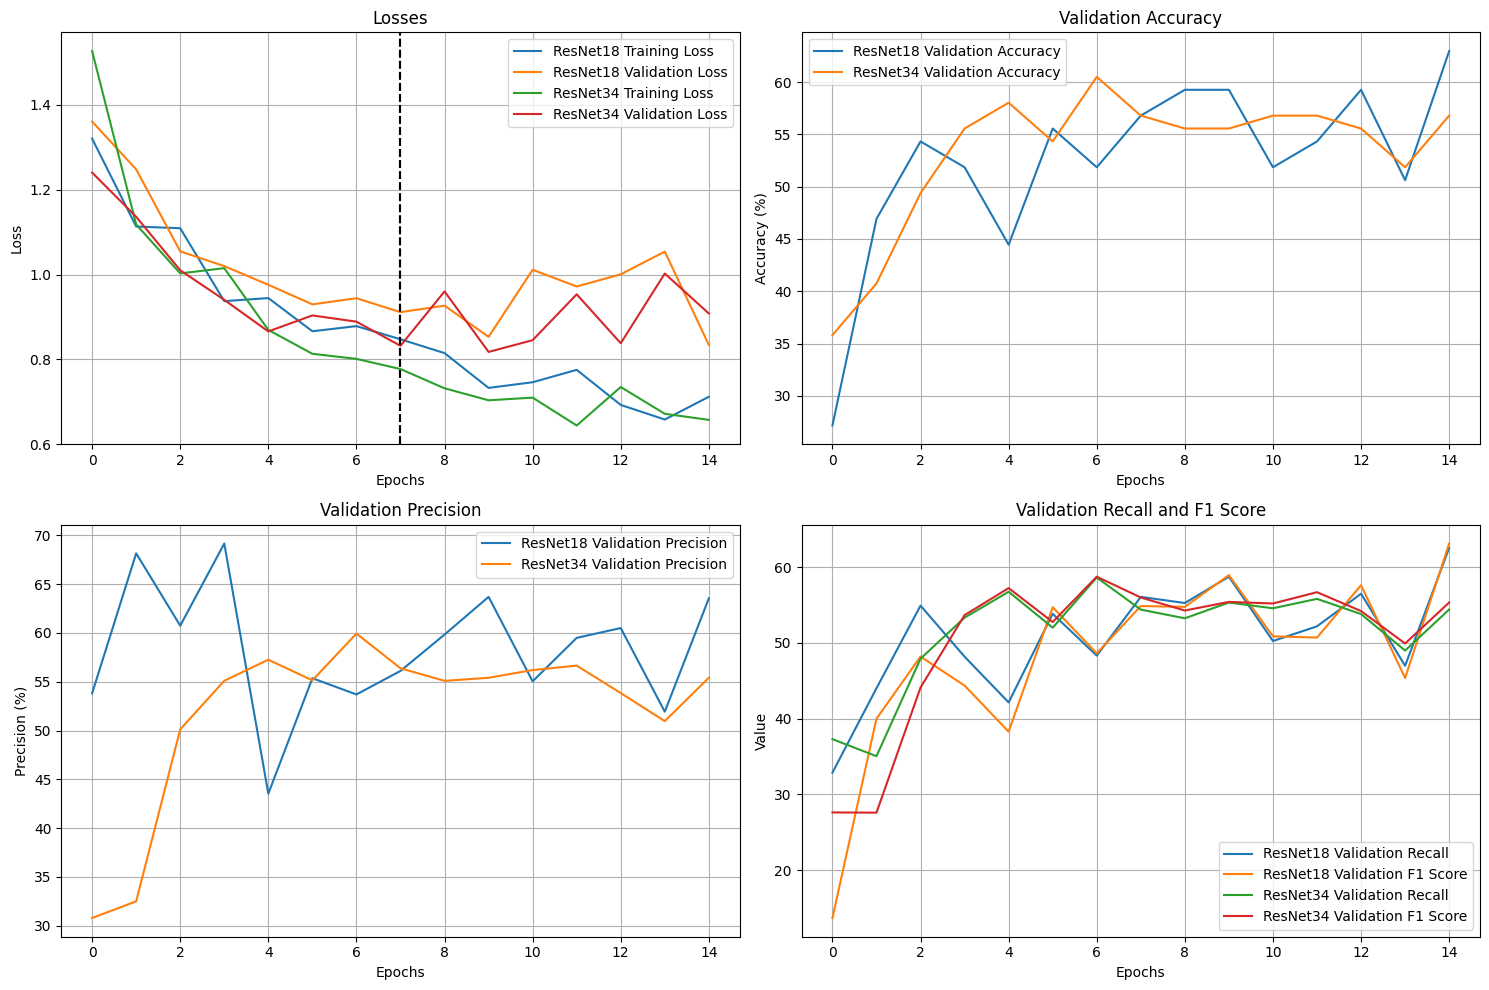

In [36]:
def visualize(metrics_dict):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for model_name, metrics in metrics_dict.items():
        cpu_metrics = {key: [val.cpu().item() if hasattr(val, 'cpu') else val for val in values] for key, values in metrics.items()}

        axs[0, 0].plot(cpu_metrics['training losses'], label=f'{model_name} Training Loss')
        axs[0, 0].plot(cpu_metrics['validation losses'], label=f'{model_name} Validation Loss')
        axs[0, 0].set_title('Losses')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].axvline(x=7, c='k', linestyle='--') #Show where overfitting starts 
        axs[0, 0].legend()
        axs[0, 0].grid(True)

        if 'validation accuracies' in cpu_metrics:
            axs[0, 1].plot(cpu_metrics['validation accuracies'], label=f'{model_name} Validation Accuracy')
            axs[0, 1].set_title('Validation Accuracy')
            axs[0, 1].set_xlabel('Epochs')
            axs[0, 1].set_ylabel('Accuracy (%)')
            axs[0, 1].legend()
            axs[0, 1].grid(True)

        if 'validation precisions' in cpu_metrics:
            axs[1, 0].plot(cpu_metrics['validation precisions'], label=f'{model_name} Validation Precision')
            axs[1, 0].set_title('Validation Precision')
            axs[1, 0].set_xlabel('Epochs')
            axs[1, 0].set_ylabel('Precision (%)')
            axs[1, 0].legend()
            axs[1, 0].grid(True)

        if 'validation recalls' in cpu_metrics and 'validation f1 scores' in cpu_metrics:
            axs[1, 1].plot(cpu_metrics['validation recalls'], label=f'{model_name} Validation Recall')
            axs[1, 1].plot(cpu_metrics['validation f1 scores'], label=f'{model_name} Validation F1 Score')
            axs[1, 1].set_title('Validation Recall and F1 Score')
            axs[1, 1].set_xlabel('Epochs')
            axs[1, 1].set_ylabel('Value')
            axs[1, 1].legend()
            axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'ResNet18': metrics_resnet18,
    'ResNet34': metrics_resnet34
}

visualize(metrics_dict)

## AMENITIES


### This will create a subfolder for each amenity category and stores the images containing said amenity in the right subfolder

In [44]:
#This is the main (big) image database folder
base_dir = 'D:\\School2(M)\\DSAIE\\STREET\\London_UK\\imagedb'

#Destination directory that saves images into created subfolders (each subfolder is an amenity category)
destination_dir = 'D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities'

#This Excel file contains  all the image data and their corresponding amenity categories
excel_file = 'Image classification.xlsx'
df = pd.read_excel(excel_file)

categories = {}

for index, row in df.iterrows():
    for category in ['f', 's_a', 's_b', 'b']:
        if pd.notna(row[category]):
            if row[category] not in categories:
                categories[row[category]] = []
            categories[row[category]].append(f"{row['Panoid']}_{category}")

for category, filenames in categories.items():

    image_paths = [os.path.join(base_dir, f"image_{filename}.png") for filename in filenames]
    
    category_path = os.path.join(destination_dir, category.strip())
    os.makedirs(category_path, exist_ok=True)
    
    for image_path, filename in zip(image_paths, filenames):
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(category_path, f"image_{filename}.png"))
        else:
            print(f"Image not found: {image_path}")

    print(f"Images copied to {category_path}")

print("✅ All images have been sorted into subfolders.")

Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Retail and Commercial Services
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Financial and Administrative Services
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Transportation and Mobility
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Public and Government Buildings
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Food and Beverage
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Food and beverage
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Residential buildings
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Greenery
Images copied to D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities\Pub

### This will create the mean and std tensor for the amenity folder, needed for training and normalization later on

In [45]:
data_dir = 'D:\School2(M)\DSAIE\STREET-main\STREET-main\Classified_images_amenities'
dataset = ImageFolder(root=data_dir, transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean_amenities = torch.tensor([0.0, 0.0, 0.0])
std_amenities = torch.tensor([0.0, 0.0, 0.0])
for images, _ in loader:

    batch_mean = torch.mean(images, dim=[0, 2, 3])
    batch_std = torch.std(images, dim=[0, 2, 3])
    mean_amenities += batch_mean
    std_amenities += batch_std
mean_amenities /= len(loader)
std_amenities /= len(loader)

print(f"Dataset Mean: {mean_amenities}, Dataset Std: {std_amenities}")


Dataset Mean: tensor([0.4202, 0.4174, 0.4124]), Dataset Std: tensor([0.2137, 0.2127, 0.2190])


### As with the road function; Applies data augmentation on our manually classified images to artificially increase training dataset size. Next it sorts the data into trainig-val-test sets and  prepares for transfer learning.

In [46]:
transform_amenities = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_amenities, std=std_amenities)
])

train_dataset = ImageFolder(root=data_dir, transform=transform_amenities)

#Split the dataset into train (70%), val (20%), and test (10%)
num_train = int(0.7 * len(train_dataset))
num_val = int(0.2 * len(train_dataset))
num_test = len(train_dataset) - num_train - num_val

train_data, val_data, test_data = random_split(train_dataset, [num_train, num_val, num_test])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(model_name, num_classes): #VGG16 takes too long to train
    if model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Unfreeze (final) classification layer
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Sequential(
        nn.Dropout(0.5), 
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    return model.to(device)

### Defines the trainer which again computes losses, accuracies and validation matrics. Again, optimizer AdamW performed best. The early stopping prevents the model from computing for all 50 epochs. 

In [47]:
def train(model, train_loader, val_loader, lr=0.005, patience=3):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss() 
    metrics = {'training losses': [], 'validation losses': [], 'validation accuracies': [], 'validation precisions': [], 'validation recalls': [], 'validation f1 scores': []}
    best_val_accuracy = 0.0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(50): 
        model.train()
        training_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        metrics['training losses'].append(training_loss / len(train_loader))

        model.eval()
        validation_loss = 0.0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        metrics['validation losses'].append(validation_loss / len(val_loader))
        accuracy = 100 * accuracy_score(true_labels, predicted_labels)
        precision = 100 * precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
        recall = 100 * recall_score(true_labels, predicted_labels, average='macro')
        f1 = 100 * f1_score(true_labels, predicted_labels, average='weighted')

        metrics['validation accuracies'].append(accuracy)
        metrics['validation precisions'].append(precision)
        metrics['validation recalls'].append(recall)
        metrics['validation f1 scores'].append(f1)

        scheduler.step(validation_loss)

        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_model_state = model.state_dict()
            epochs_no_improve = 0
            print(f"Epoch {epoch+1}: Improved validation accuracy to {best_val_accuracy:.2f}%.")
        else:
            epochs_no_improve += 1

        print(f'Epoch {epoch+1}/{50}', f'Train Loss: {metrics["training losses"][-1]:.4f}, ', f'Validation Loss: {metrics["validation losses"][-1]:.4f}, ', f'Accuracy: {metrics["validation accuracies"][-1]:.2f}%')
        
        #Patience is set to 3; Early stopping triggers when validation accuracy doesn't improve for 3 consecutive epochs
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

    return metrics, best_val_accuracy, best_model_state

### Trains the models, determines and saves the best performing model with the lowest validation loss (Resnet34 in this case). It also computes validation metrics. 

In [48]:
#Train and evaluate ResNet18
model_resnet18 = create_model("resnet18", len(train_dataset.classes))
summary(model_resnet18, input_size=(3, 224, 224))

metrics_resnet18, best_val_accuracy_resnet18, best_model_state_resnet18 = train(model_resnet18, train_loader, val_loader)

#Train and evaluate ResNet34
model_resnet34 = create_model("resnet34", len(train_dataset.classes))
summary(model_resnet34, input_size=(3, 224, 224))

metrics_resnet34, best_val_accuracy_resnet34, best_model_state_resnet34 = train(model_resnet34, train_loader, val_loader)

#Determine best performing model
if best_val_accuracy_resnet18 > best_val_accuracy_resnet34:
    best_model_state = best_model_state_resnet18
    best_model_name = "ResNet18"
else:
    best_model_state = best_model_state_resnet34
    best_model_name = "ResNet34"

best_model_path = 'D:\\School2(M)\\DSAIE\\STREET-main\\STREET-main\\Models\\best_model_amenities.pth'
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
torch.save(best_model_state, best_model_path)
print(f"Best model ({best_model_name}) saved as {best_model_path}")

def evaluate(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100 * accuracy_score(true_labels, predicted_labels)
    precision = 100 * precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = 100 * recall_score(true_labels, predicted_labels, average='macro')
    f1 = 100 * f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Test Precision: {precision:.2f}%')
    print(f'Test Recall: {recall:.2f}%')
    print(f'Test F1 Score: {f1:.2f}%')

if best_model_name == "ResNet18":
    model = create_model("resnet18", len(train_dataset.classes))
else:
    model = create_model("resnet34", len(train_dataset.classes))

model.load_state_dict(torch.load(best_model_path))

#Evaluates the best model on the test set
print(f"Evaluating {best_model_name} on test set:")
evaluate(model, test_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Improved validation accuracy to 16.67%.
Epoch 1/50 Train Loss: 2.7158,  Validation Loss: 2.3295,  Accuracy: 16.67%
Epoch 2: Improved validation accuracy to 24.36%.
Epoch 2/50 Train Loss: 2.4089,  Validation Loss: 2.4119,  Accuracy: 24.36%
Epoch 3: Improved validation accuracy to 34.62%.
Epoch 3/50 Train Loss: 2.2337,  Validation Loss: 2.2240,  Accuracy: 34.62%
Epoch 4/50 Train Loss: 1.9981,  Validation Loss: 1.9860,  Accuracy: 32.05%
Epoch 5/50 Train Loss: 1.6946,  Validation Loss: 1.9980,  Accuracy: 25.64%
Epoch 6/50 Train Loss: 1.5923,  Validation Loss: 1.9926,  Accuracy: 33.33%
Early stopping!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
  

c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Improved validation accuracy to 11.54%.
Epoch 1/50 Train Loss: 2.8994,  Validation Loss: 2.6059,  Accuracy: 11.54%
Epoch 2: Improved validation accuracy to 29.49%.
Epoch 2/50 Train Loss: 2.5505,  Validation Loss: 2.1599,  Accuracy: 29.49%
Epoch 3/50 Train Loss: 2.1390,  Validation Loss: 2.0530,  Accuracy: 28.21%
Epoch 4: Improved validation accuracy to 32.05%.
Epoch 4/50 Train Loss: 1.8447,  Validation Loss: 2.0979,  Accuracy: 32.05%
Epoch 5: Improved validation accuracy to 37.18%.
Epoch 5/50 Train Loss: 1.8030,  Validation Loss: 1.9323,  Accuracy: 37.18%
Epoch 6/50 Train Loss: 1.7179,  Validation Loss: 2.0717,  Accuracy: 29.49%
Epoch 7/50 Train Loss: 1.4480,  Validation Loss: 1.9642,  Accuracy: 32.05%
Epoch 8/50 Train Loss: 1.3697,  Validation Loss: 1.9983,  Accuracy: 30.77%
Early stopping!
Best model (ResNet34) saved as D:\School2(M)\DSAIE\STREET-main\STREET-main\Models\best_model_amenities.pth


C:\Users\lucia\AppData\Local\Temp\ipykernel_5616\3346144944.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Evaluating ResNet34 on test set:
Test Accuracy: 22.50%
Test Precision: 37.73%
Test Recall: 11.98%
Test F1 Score: 21.23%


c:\Users\lucia\anaconda3\envs\dsaie\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualizes the train- and validation loss, validation accuracy, precision and recall&F1-score (weighted)

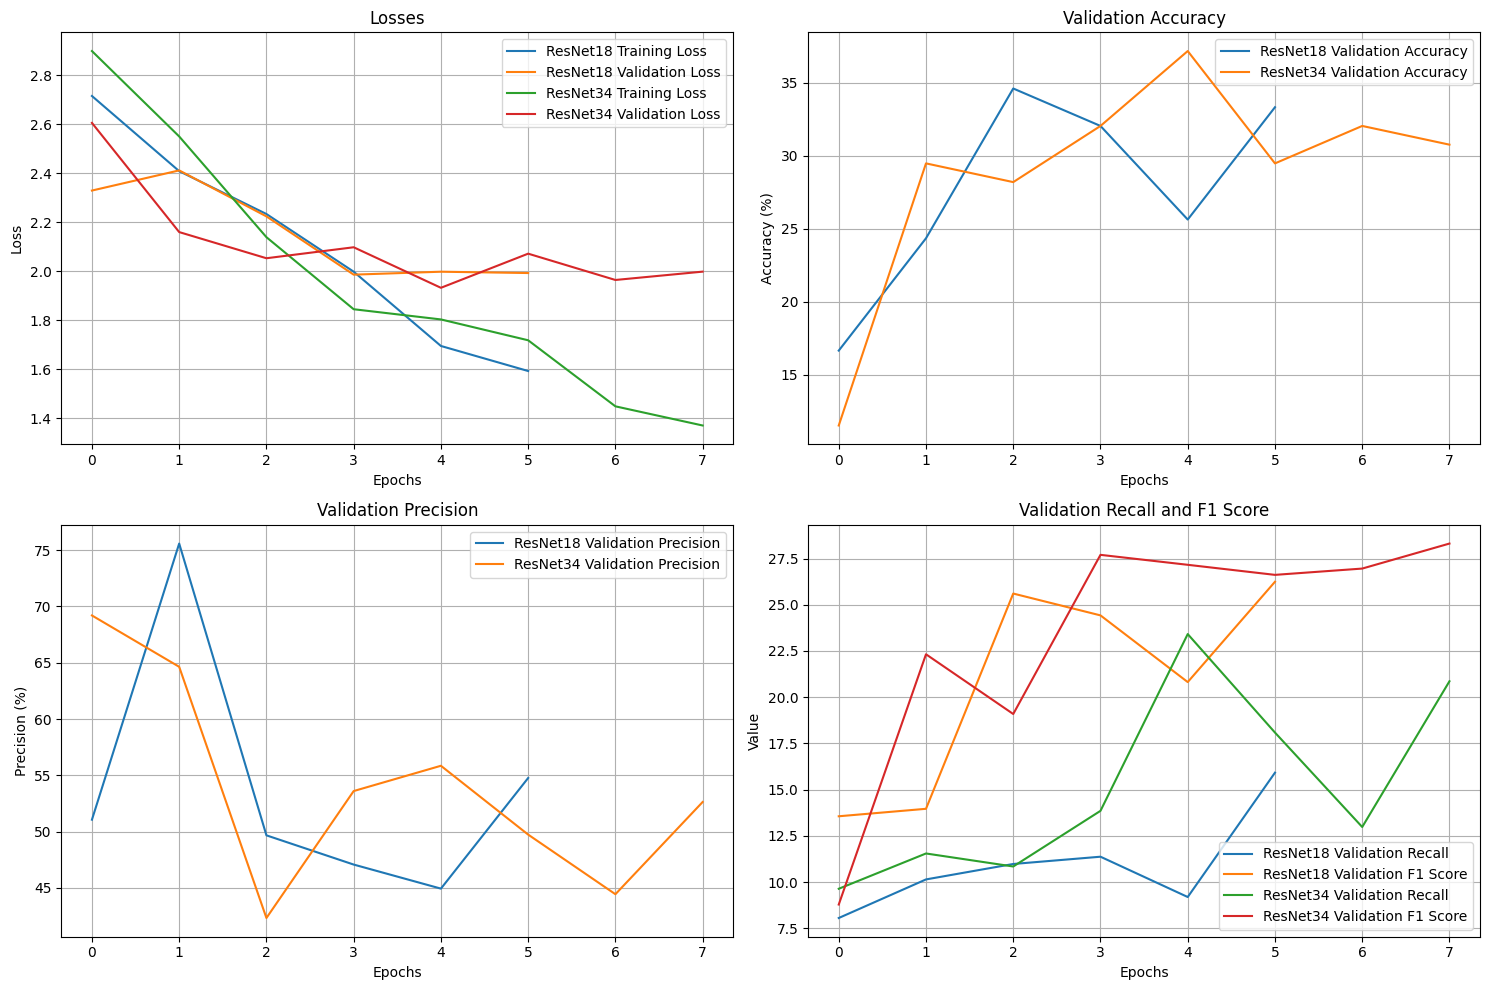

In [51]:
def visualize(metrics_dict):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10)) 

    for model_name, metrics in metrics_dict.items():
        cpu_metrics = {key: [val.cpu().item() if hasattr(val, 'cpu') else val for val in values] for key, values in metrics.items()}

        axs[0, 0].plot(cpu_metrics['training losses'], label=f'{model_name} Training Loss')
        axs[0, 0].plot(cpu_metrics['validation losses'], label=f'{model_name} Validation Loss')
        axs[0, 0].set_title('Losses')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()
        axs[0, 0].grid(True)

        if 'validation accuracies' in cpu_metrics:
            axs[0, 1].plot(cpu_metrics['validation accuracies'], label=f'{model_name} Validation Accuracy')
            axs[0, 1].set_title('Validation Accuracy')
            axs[0, 1].set_xlabel('Epochs')
            axs[0, 1].set_ylabel('Accuracy (%)')
            axs[0, 1].legend()
            axs[0, 1].grid(True)

        if 'validation precisions' in cpu_metrics:
            axs[1, 0].plot(cpu_metrics['validation precisions'], label=f'{model_name} Validation Precision')
            axs[1, 0].set_title('Validation Precision')
            axs[1, 0].set_xlabel('Epochs')
            axs[1, 0].set_ylabel('Precision (%)')
            axs[1, 0].legend()
            axs[1, 0].grid(True)

        if 'validation recalls' in cpu_metrics and 'validation f1 scores' in cpu_metrics:
            axs[1, 1].plot(cpu_metrics['validation recalls'], label=f'{model_name} Validation Recall')
            axs[1, 1].plot(cpu_metrics['validation f1 scores'], label=f'{model_name} Validation F1 Score')
            axs[1, 1].set_title('Validation Recall and F1 Score')
            axs[1, 1].set_xlabel('Epochs')
            axs[1, 1].set_ylabel('Value')
            axs[1, 1].legend()
            axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

#Visualize both ResNet18 and ResNet34 metrics
metrics_dict = {
    'ResNet18': metrics_resnet18,
    'ResNet34': metrics_resnet34
}

visualize(metrics_dict)